In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import pandas as pd
import openturns as ot
print(f"Using device: {device}")
import pyvinecopulib as pv
from scipy.stats import gaussian_kde
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import norm
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

Using device: cuda


In [4]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"

dim = 2
base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)

num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 10 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 10* latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 128
loss_history = []
epochs = 100

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [ ]:
n_samples = 10000
n_experiments = 100
seed = 1234
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

for i in range(n_experiments):
    Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))
    cop = Gumble
    # print(cop)

    U = cop.simulate(n_samples, seeds = np.array([seed+i, seed+i+1]))

    alpha = 2.0
    beta  = 1.0  # scale


    margin1 = norm.ppf(U[:,0], loc=1, scale=3)
    margin2 = norm.ppf(U[:,1], loc=2, scale=5)

    samples_origin = np.stack([margin1,margin2],axis=1)
    # sns.pairplot(pd.DataFrame(samples_origin),diag_kws={'bins': 10})

    thres = np.quantile(samples_origin, 0.95,axis=0)

    cond = (samples_origin[:,0] > thres[0] ) | (samples_origin[:,1] > thres[1] ) 
    samples = samples_origin[cond,:]

    thres = thres.reshape(1,-1)
    samples = samples - thres
    print(samples.shape)

    data = torch.tensor(samples, dtype=torch.float, device = device)
    print(data.shape)

    memory = torch.cuda.memory_allocated(device) /10**9
    print('{:.2f}G GPU memory allocated'.format(memory))


    Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for x_data in Training_Data:
            # Sample a batch of data from h_U

            batch_loss = model(x_data)

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


            optimizer.step()

            # Record loss
            loss_history.append(batch_loss.item())
            epoch_loss += batch_loss.item()

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print("NaN or Inf detected!")
                break

        # Debugging: Print shapes

        scheduler.step()
    torch.save(model.state_dict(), dir_out + f'model_2D_10k_{i}.pt')
    with open(dir_out + f'data_2D_10k_{i}.npy', 'wb') as f:
        np.save(f, samples_origin)
        np.save(f, thres)
    print(f"Completed Experiment {i} \n")



(825, 2)
torch.Size([825, 2])
0.00G GPU memory allocated
Completed Experiment 0 

(830, 2)
torch.Size([830, 2])
0.02G GPU memory allocated
Completed Experiment 1 

(841, 2)
torch.Size([841, 2])
0.02G GPU memory allocated
Completed Experiment 2 

(847, 2)
torch.Size([847, 2])
0.02G GPU memory allocated
Completed Experiment 3 

(845, 2)
torch.Size([845, 2])
0.02G GPU memory allocated
Completed Experiment 4 

(821, 2)
torch.Size([821, 2])
0.02G GPU memory allocated
Completed Experiment 5 

(835, 2)
torch.Size([835, 2])
0.02G GPU memory allocated
Completed Experiment 6 

(834, 2)
torch.Size([834, 2])
0.02G GPU memory allocated
Completed Experiment 7 

(837, 2)
torch.Size([837, 2])
0.02G GPU memory allocated
Completed Experiment 8 

(829, 2)
torch.Size([829, 2])
0.02G GPU memory allocated
Completed Experiment 9 

(831, 2)
torch.Size([831, 2])
0.02G GPU memory allocated
Completed Experiment 10 

(842, 2)
torch.Size([842, 2])
0.02G GPU memory allocated
Completed Experiment 11 

(848, 2)
torch

In [1]:
def marginal_density_comparison(data, i, model, n_experiments):
    margin = data[:,i]  # Example data
    # Step 1: Estimate the KDE of the data and get the KDE values
    kde = gaussian_kde(margin)
    tail_range = ( max(margin) - min(margin))/5
    x_values = np.linspace(min(margin) - tail_range, max(margin) + tail_range, 1000)
    kde_values = kde(x_values)
    
    # Step 2: Generate samples and compute their KDEs
    n_samples = len(margin)
    sample_kdes = []
    
    for _ in range(n_experiments):  # Step 3: Repeat 200 times
        model.load_state_dict(torch.load(dir_out + f'model_2D_10k_{_}.pt', weights_only=True))
        model.eval()
        samples_obs, samples_std, samples_T= model.sample(data.shape[0])
        sampled_data = samples_obs[:,i].cpu().data.numpy()
        sample_kde = gaussian_kde(sampled_data)
        sample_kde_values = sample_kde(x_values)
        sample_kdes.append(sample_kde_values)
    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_kdes = np.array(sample_kdes)
    mean = np.mean(sample_kdes, axis=0)
    lower_bound = np.percentile(sample_kdes, 2.5, axis=0)
    upper_bound = np.percentile(sample_kdes, 97.5, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the KDE of the data
    sns.lineplot(x=x_values, y=kde_values, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=x_values, y=mean, linestyle='dashdot', color='cornflowerblue', label='Monte Carlo Mean', linewidth=1.5)
    # sns.lineplot(x=x_values, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=x_values, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)

    # Plot the credible interval as a ribbon
    ax.fill_between(x_values, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

    ax.set_title('Marignal Density of Dimension {}'.format(dim), fontsize=14)


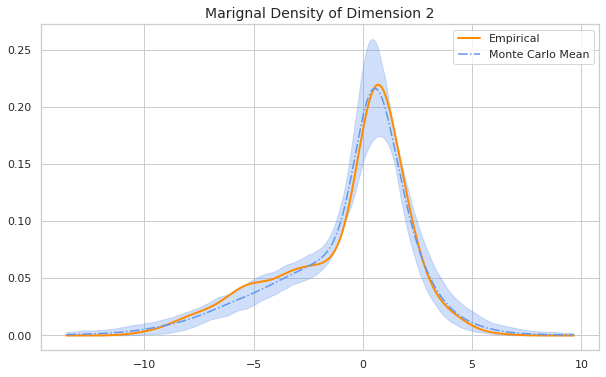

In [10]:
marginal_density_comparison(data= samples, i = 0, model=model, n_experiments = 100)

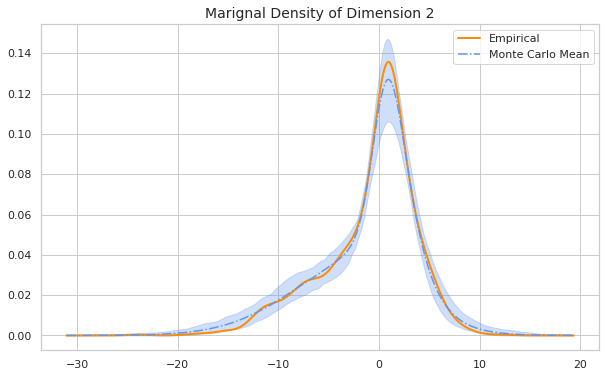

In [11]:
marginal_density_comparison(data= samples, i = 1, model=model,  n_experiments = 100)

In [7]:
def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u

def plot_tail_dependence(data, i, j, model, n_experiments):
    probs = np.linspace(0.80, 0.99, 100)
    # Compute lambda_u for each quantile
    chi_emp = [empirical_upper_tail_dependence(data[:,[i,j]], p) for p in probs]
    

    # Step 2: Generate samples and compute their KDEs
    n_samples = data.shape[0]
    sample_chi = []
    
    for _ in range(n_experiments):  # Step 3: Repeat 200 times
        model.load_state_dict(torch.load(dir_out + f'model_2D_10k_{_}.pt', weights_only=True))
        model.eval()
        samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
        sampled_data = samples_obs.cpu().data.numpy()
        sample_chi.append( [empirical_upper_tail_dependence(sampled_data[:,[i,j]], p) for p in probs])

    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_chi = np.array(sample_chi)
    lower_bound = np.percentile(sample_chi, 2.5, axis=0)
    upper_bound = np.percentile(sample_chi, 97.5, axis=0)
    mean = np.mean(sample_chi, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the KDE of the data
    sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
    # sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
    ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
    
    ax.set_title('Chi Between Dimension {} and {}'.format(i+1,j+1), fontsize=14)

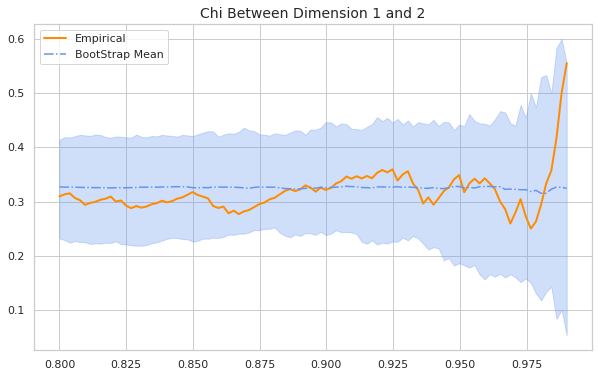

In [13]:
plot_tail_dependence(samples, i=0, j=1, model=model, n_experiments= 100)


In [8]:
n_experiments = 100
n_model_sample = 1000

seed = 1234
Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))
cop = Gumble
# print(cop)


probs = np.linspace(0.80, 0.996, 100)

Cuu = cop.cdf(np.stack([probs,probs],axis=1))
chi_theorical = (1 - 2*probs + Cuu)/(1-probs)

probs = np.linspace(0.80, 0.996, 100)
# Compute lambda_u for each quantile

# Step 2: Generate samples and compute their KDEs
sample_chi = []

for _ in range(n_experiments):  # Step 3: Repeat 200 times
    model.load_state_dict(torch.load(dir_out + f'model_2D_10k_{_}.pt', weights_only=True))
    model.eval()
    samples_obs, samples_std, samples_T= model.sample(n_model_sample)
    sampled_data = samples_obs.cpu().data.numpy()
    sample_chi.append( [empirical_upper_tail_dependence(sampled_data, p) for p in probs])


# Step 3: Calculate the 95% credible interval for the KDE of the samples
sample_chi = np.array(sample_chi)
lower_bound = np.percentile(sample_chi, 2.5, axis=0)
upper_bound = np.percentile(sample_chi, 97.5, axis=0)
mean = np.mean(sample_chi, axis=0)



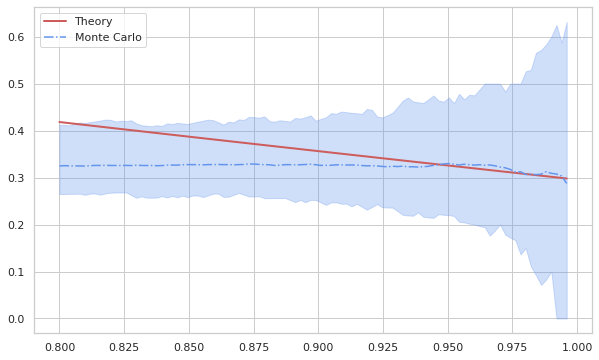

In [9]:
# Step 4: Plot the KDE of the data and the credible intervals with Seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE of the data
sns.lineplot(x=probs, y=chi_theorical, label='Theory', color='indianred', linewidth=2)
# plt.hlines(y=chi_theorical, xmin=0.99, xmax=1, color='darkorange', linewidth=3)
# Plot the credible intervals
sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='Monte Carlo', linewidth=1.5)
# sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
# sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

In [10]:
def empirical_survival(X, u, sign):

    # Compute the quantiles
    n_obs = X.shape[0]
    n_dim = X.shape[1]
    cond = np.array([True]*n_obs)
    sign = list(sign)
    for j in range(n_dim):
        s = sign.pop(0)
        if s == '>':
            cond &= X[:,j] > u[j]
        else:
            cond &= X[:,j] < u[j]
    # Count joint exceedances
    joint_exceedance = np.sum(cond)

    return joint_exceedance/n_obs

def plot_survival_prob(data, u, sign, prob_exceed, model, n_bootstrap, n_model_sample):
    
    # Compute lambda_u for each quantile
    prob_emp = np.log(empirical_survival(data, u, sign))
    

    # Step 2: Generate samples and compute their KDEs
    n_samples = data.shape[0]
    sample_prob = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(n_model_sample)
        sampled_data = samples_obs.cpu().data.numpy() + thres
        sample_prob.append( np.log(empirical_survival(sampled_data, u, sign))+ np.log(prob_exceed))

    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_prob = np.array(sample_prob)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    
    
    # Plot the KDE of the data
    ax = sns.boxplot(data=sample_prob, fill=False, color='cornflowerblue', label='BootStrap Prob')
    ax.axhline(prob_emp, color='darkorange', linewidth=2, label='Empirical')
    # ax.set_title('Chi Between Dimension {} and {}'.format(i+1,j+1), fontsize=14)

In [11]:
prob_exceed = (samples.shape[0])/samples_origin.shape[0]

NameError: name 'samples' is not defined

In [18]:
thres

array([[ 5.90036729, 10.12178529]])

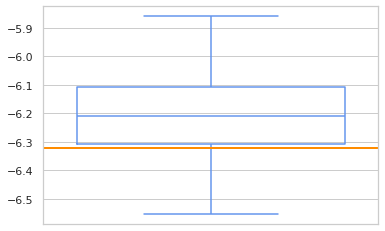

In [19]:
# plot_survival_prob(data= samples_origin, u = [6,15], sign="<>",prob_exceed=prob_exceed,  model= model, n_bootstrap=20,n_model_sample=samples.shape[0])
plot_survival_prob(data= samples_origin, u = [6,15], sign="<>",prob_exceed=prob_exceed,  model= model, n_bootstrap=20,n_model_sample=1000)

In [15]:
n_model_sample = 1000000
n_bootstrap = 100

u1 = np.arange(0.3,1,0.1)
u2 = np.array([0.99]*len(u1))
prob_non_exceed = cop.cdf(np.stack([u1,u2],axis=1))

prob_partial_exceed = {}
prob = np.log(u1 - prob_non_exceed)
for i in range(len(u1)):
    prob_partial_exceed[f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})'] = prob[i]


x1 = norm.ppf(u1, loc=1, scale=3)
# x2 = expon.ppf(u2,  scale =5 )
x2 = norm.ppf(u2, loc=2, scale=5)

prob_exceed_dict =   dict([(f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})', []) for i in range(len(x1))])
for _ in range(n_experiments):  # Step 3: Repeat 200 times
    model.load_state_dict(torch.load(dir_out + f'model_2D_10k_{_}.pt', weights_only=True))
    model.eval()
    samples_obs, samples_std, samples_T= model.sample(n_model_sample)
    

    with open(dir_out + f'data_2D_10k_{i}.npy', 'rb') as f:
        samples_origin = np.load(f)
        thres = np.load(f)
    samples_data = samples_obs.cpu().data.numpy() + thres
    prob_exceed = np.mean((samples_origin[:,0]>thres.flatten()[0]) | (samples_origin[:,1]>thres.flatten()[1] ) )
    for i in range(len(x1)):
        val = np.log(empirical_survival(samples_data, [x1[i],x2[0]], "<>"))+ np.log(prob_exceed)
        prob_exceed_dict[f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})'].append(val)

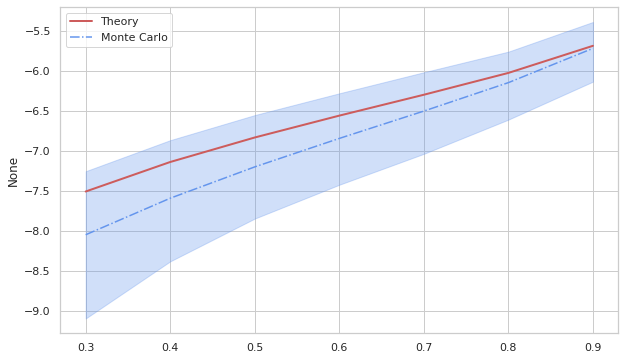

In [16]:
df = pd.DataFrame(prob_exceed_dict)
prob_partial_exceed_list = [value for key, value in prob_partial_exceed.items() ]

mean = np.mean(df,axis=0)
lower_bound = np.quantile(df, 0.025, axis=0)
upper_bound = np.quantile(df, 0.975, axis=0)
# Create the boxplot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=u1, y=prob_partial_exceed_list, label='Theory', color='indianred', linewidth=2)

sns.lineplot(x=u1, y=mean, linestyle='dashdot', color='cornflowerblue', label='Monte Carlo', linewidth=1.5)

ax.fill_between(u1, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

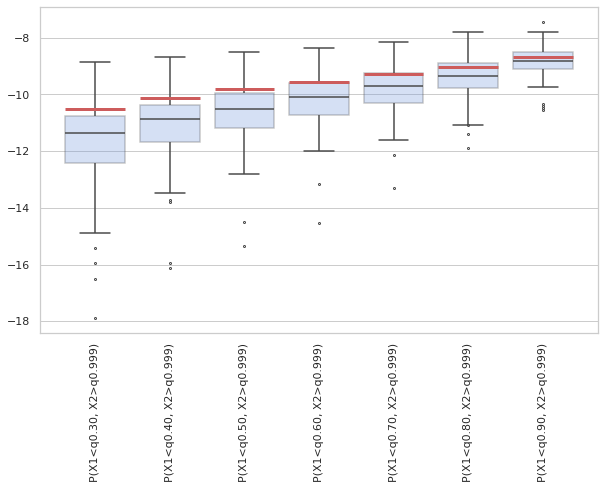

In [40]:
df = pd.DataFrame(prob_exceed_dict)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
plt.xticks(rotation=90)
for i, prob_index in enumerate(prob_partial_exceed):
    plt.hlines(y=prob_partial_exceed[prob_index], xmin=i - 0.4, xmax=i + 0.4, color='indianred', linewidth=3)

In [59]:
np.exp(-9)

np.float64(0.00012340980408667956)